# Proyecto 1: Regresión Lineal

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Carga de dataset


In [63]:
dataset = pd.read_csv('forestfires.csv')
dataset = dataset.sort_values(by=['month', 'day', 'temp'])
# mostrar solo el temp mas alto de cada mes y dia
# dataset = dataset.drop_duplicates(subset=['month', 'day'], keep='last')
dataset

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
241,4,4,apr,fri,83.0,23.3,85.3,2.3,16.7,20,3.1,0.0,0.00
442,6,5,apr,mon,87.9,24.9,41.6,3.7,10.9,64,3.1,0.0,3.35
19,6,4,apr,sat,86.3,27.4,97.1,5.1,9.3,44,4.5,0.0,0.00
239,7,5,apr,sun,81.9,3.0,7.9,3.5,13.4,75,1.8,0.0,0.00
469,6,3,apr,sun,91.0,14.6,25.6,12.3,13.7,33,9.4,0.0,61.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,4,5,sep,wed,92.9,133.3,699.6,9.2,24.3,25,4.0,0.0,9.41
313,6,5,sep,wed,92.6,115.4,777.1,8.8,24.3,27,4.9,0.0,0.00
45,5,6,sep,wed,94.3,85.1,692.3,15.9,25.9,24,4.0,0.0,0.00
14,6,5,sep,wed,92.9,133.3,699.6,9.2,26.4,21,4.5,0.0,0.00


## Análisis Exploratorio

### Correlación de las variables
No se consideran las variables `month` y `day` ya que son variables categóricas

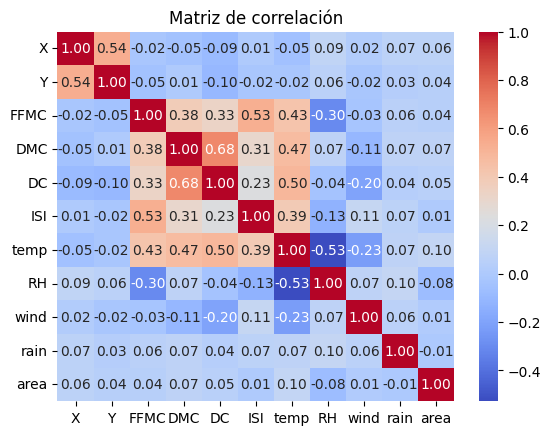

In [66]:
showcorr = dataset.drop(columns=['month', 'day'])
sns.heatmap(np.corrcoef(showcorr.T), annot=True, cmap='coolwarm', fmt=".2f", 
                        xticklabels=showcorr.columns, yticklabels=showcorr.columns)
plt.title("Matriz de correlación")
plt.show()

### Quitando features con menor correlación al objetivo

In [43]:
# transformacion logaritmica porque la variable area esta muy sesgada
dataset = dataset[dataset['area'] > 0].drop(columns=['month', 'day'])
temp = dataset['area']
dataset['area'] = np.log1p(dataset['area'])
# quitar los areas con valores nulos
Xpd = dataset.iloc[:, :-1]
Ypd = dataset.iloc[:, -1]
# print(Ypd.shape, Xpd.shape)

In [44]:
X = Xpd.to_numpy().astype(np.float32)
yreal = Ypd.to_numpy().astype(np.float32)

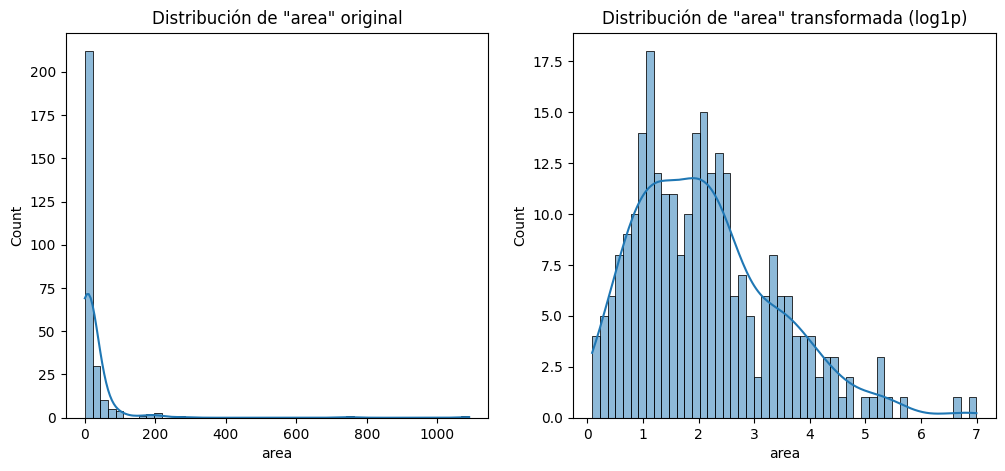

In [45]:
# Graficar la distribución de área original
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(temp, bins=50, kde=True)
plt.title('Distribución de "area" original')

# Graficar la distribución de 'area' transformada
plt.subplot(1,2,2)
sns.histplot(Ypd, bins=50, kde=True)
plt.title('Distribución de "area" transformada (log1p)')
plt.show()

## Regresión multivariable

In [56]:
class NoLinearRegression:
    def __init__(self, X_train, Y_train, alpha, _lambda):
        self._lambda = _lambda
        self.X_train: np.ndarray = X_train
        self.Y_train: np.ndarray = Y_train
        self.W = [1] + list(np.random.rand(X_train.shape[1]))
        # print(self.X_train.shape)
        # print(len(self.W))
        self.alpha = alpha

    def H(self, X, W):
        return np.dot(X, W)
    
    def Loss(self):
        n = len(self.Y_train)
        return (1/(2*n)) * (np.linalg.norm(self.Y_train - self.H(self.X_train, self.W)) ** 2)
    
    def Lasso(self):
        return self.Loss() + (self._lambda * np.sum(np.abs(self.W)))
    
    def Ridge(self):
        return self.Loss() + (self._lambda * np.linalg.norm(self.W) ** 2)
    
    def Derivative(self):
        n = len(self.Y_train)
        return (1/n) * np.dot(self.X_train.T, self.Y_train - self.H(self.X_train, self.W))
    
    def LassoDerivative(self):
        return self.Derivative() + self._lambda * np.sum(np.abs(self.W))
    
    def RidgeDerivative(self):
        return self.Derivative() + 2 * (self._lambda * np.linalg.norm(self.W) ** 2)

    def LassoUpdate(self):
        self.W = self.W - self.alpha * self.LassoDerivative()

    def RidgeUpdate(self):
        self.W = self.W - self.alpha * self.RidgeDerivative()

    def reset(self, Y_train):
        self.W = np.random.rand(self.X_train.shape[1])
        self.Y_train = Y_train

    def LassoTrain(self, epochs):
        L = self.Lasso()
        L_reg = []
        for _ in range(epochs):
            self.LassoUpdate()
            self.Y_train = self.H(self.X_train, self.W)
            L = self.Lasso()
            L_reg.append(L)
        return L, L_reg

    def RidgeTrain(self, epochs):
        L = self.Ridge()
        L_reg = []
        for _ in range(epochs):
            self.RidgeUpdate()
            self.Y_train = self.H(self.X_train, self.W)
            L = self.Ridge()
            L_reg.append(L)
        return L, L_reg

## Training y Testing

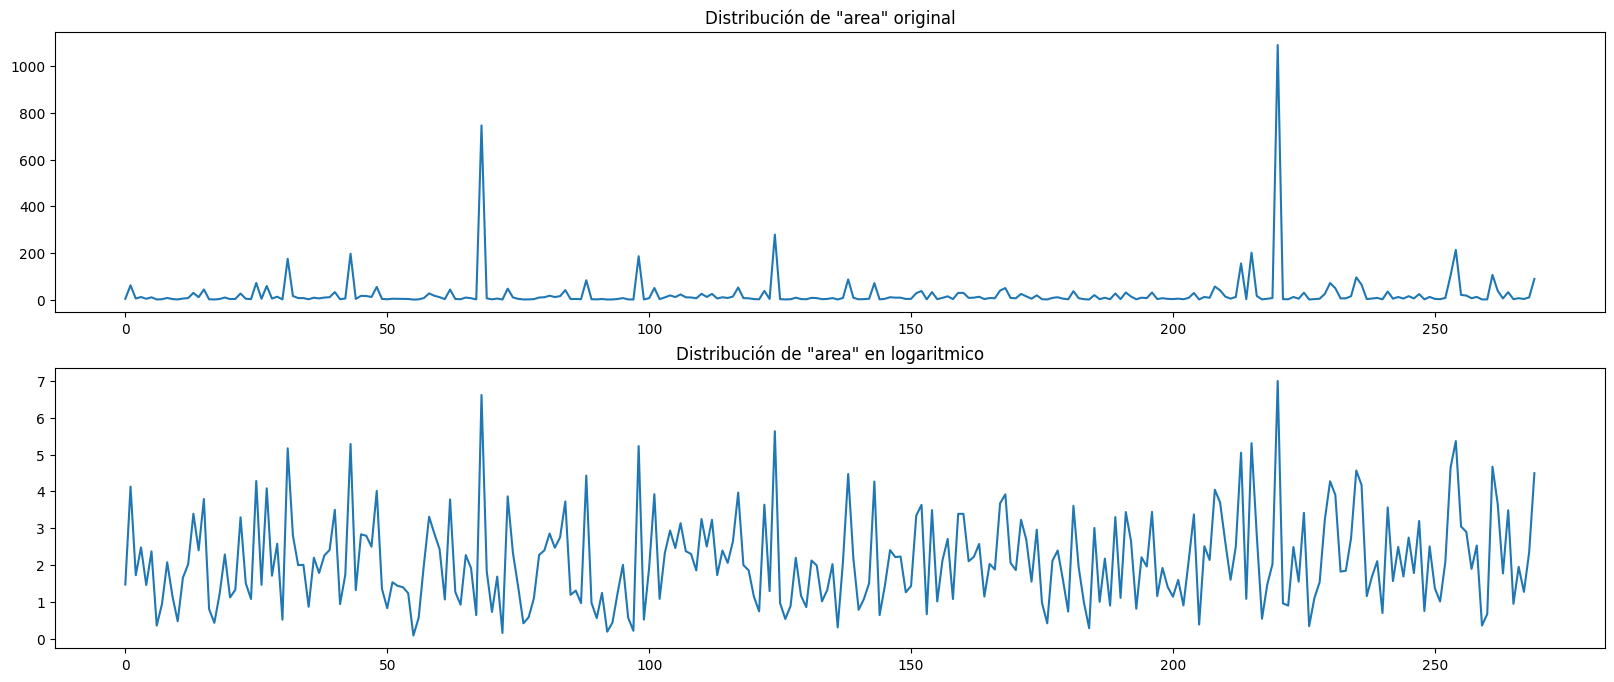

In [57]:
# Xpd['month'] = pd.Categorical(Xpd['month'], categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']).codes
# Xpd['day'] = pd.Categorical(Xpd['day'], categories=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']).codes

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(range(Xpd.shape[0]), temp)
plt.title('Distribución de "area" original')

plt.subplot(2,1,2)
plt.plot(range(Xpd.shape[0]), yreal)
plt.title('Distribución de "area" en logaritmico')

plt.show()

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, yreal, test_size = 0.3, random_state = 0)
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [58]:
epochs = 1000
alpha = 0.01
_lambda = 0.01
lineal = NoLinearRegression(X_train, y_train, alpha, _lambda)
lineal.reset(y_train)

### Con regul. Lasso

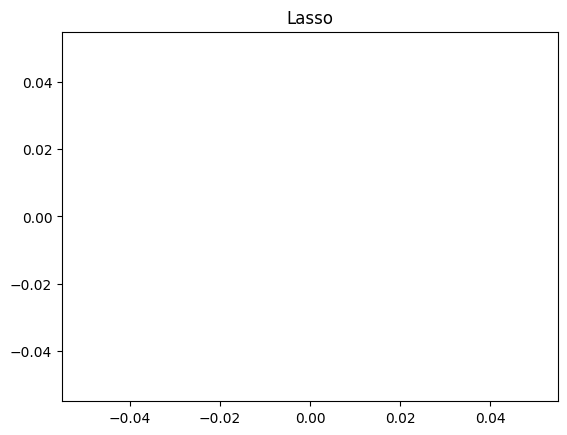

In [62]:
L_lasso, L_reg_lasso = lineal.LassoTrain(epochs)
sns.lineplot(x=range(epochs), y=L_reg_lasso)
plt.title('Lasso')
plt.show()

### Con regul. Ridge

/tmp/ipykernel_429756/3828169547.py:16: RuntimeWarning: invalid value encountered in subtract
  return (1/(2*n)) * (np.linalg.norm(self.Y_train - self.H(self.X_train, self.W)) ** 2)
/tmp/ipykernel_429756/3828169547.py:26: RuntimeWarning: invalid value encountered in subtract
  return (1/n) * np.dot(self.X_train.T, self.Y_train - self.H(self.X_train, self.W))


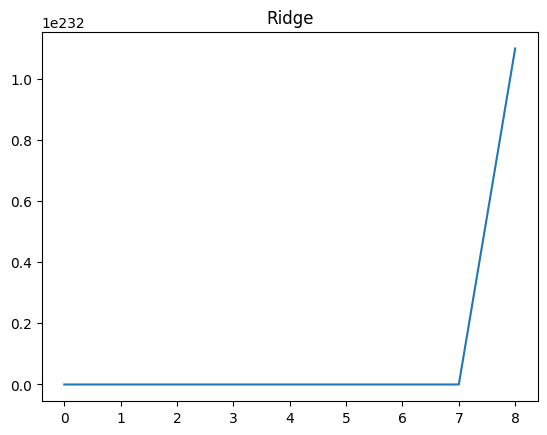

In [61]:
lineal.reset(y_train)
L_Ridge, L_reg_Ridge = lineal.RidgeTrain(epochs)
sns.lineplot(x=range(epochs), y=L_reg_Ridge)
plt.title('Ridge')
plt.show()

print()

Correlación entre X y area: 0.004017696159530449
Correlación entre Y y area: 0.0020136063329226905
Correlación entre FFMC y area: 0.001609775217704382
Correlación entre DMC y area: 0.005328167285187107
Correlación entre DC y area: 0.0024387029409235162
Correlación entre ISI y area: 6.818940848314467e-05
Correlación entre temp y area: 0.009573469341491087
Correlación entre RH y area: 0.005703053428555678
Correlación entre wind y area: 0.00015171530995224054
Correlación entre rain y area: 5.425396781582366e-05


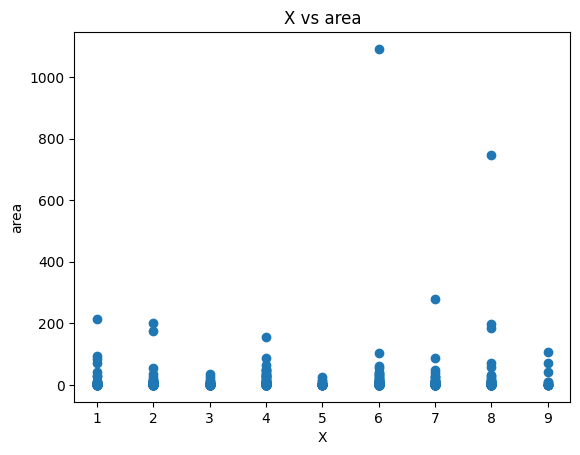

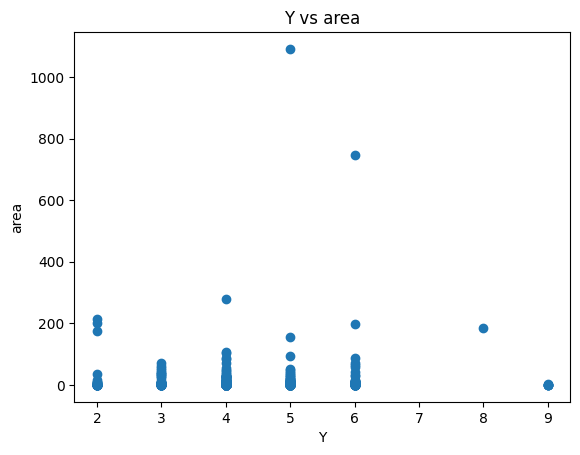

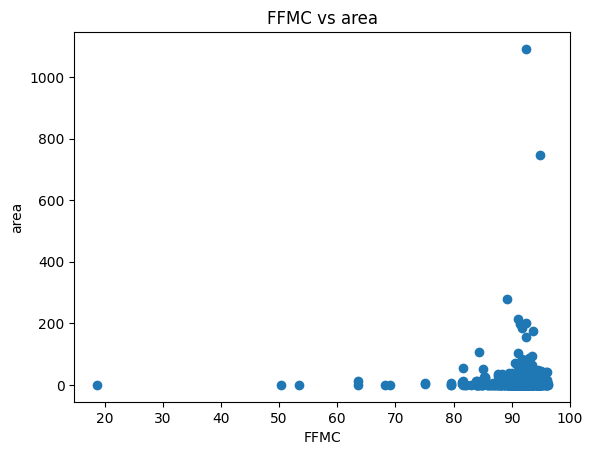

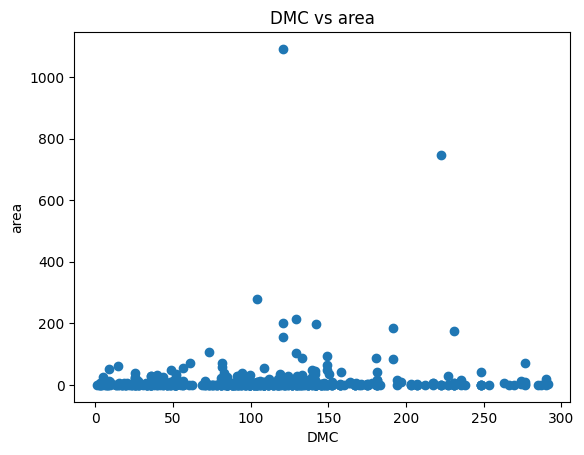

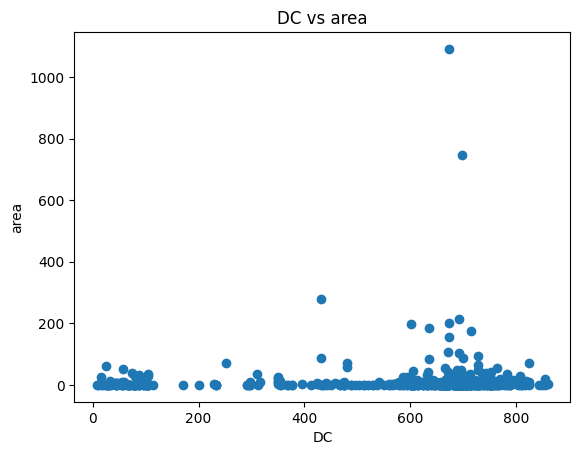

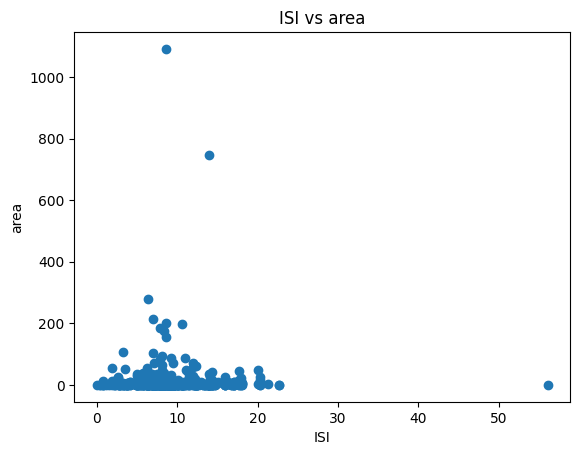

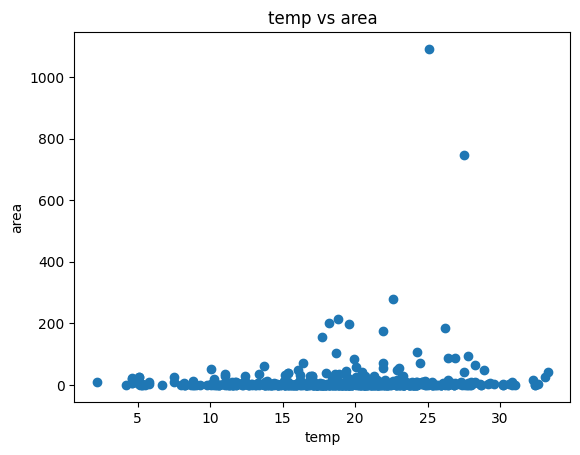

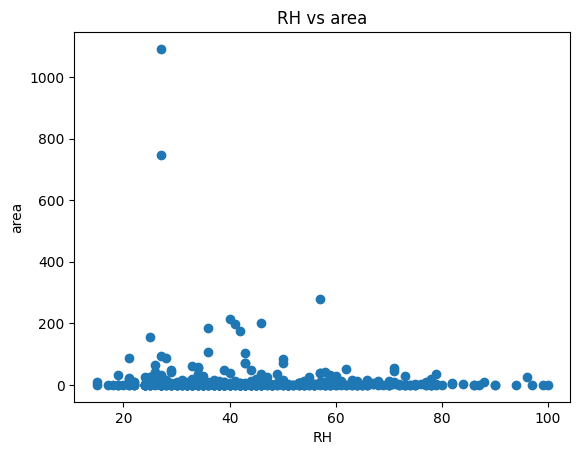

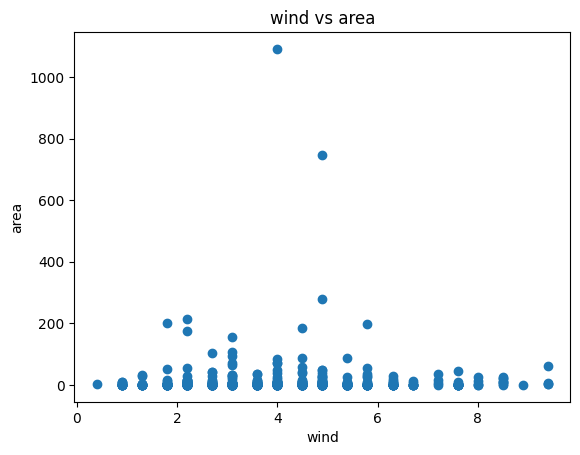

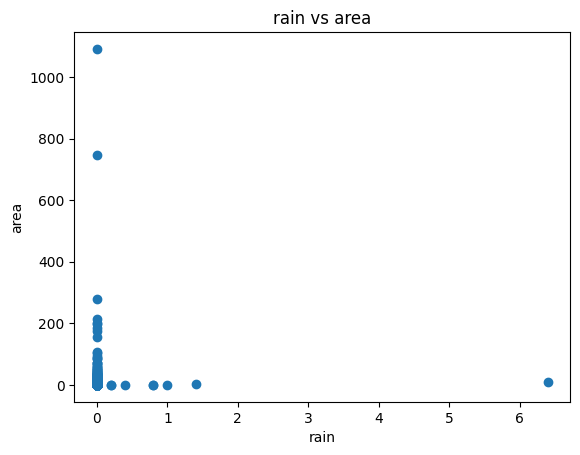

In [65]:
df = pd.read_csv("forestfires.csv")
y = df["area"].to_numpy()

df = df.drop(columns=["month", "day", "area"])

# OBTENER LA CORRELACION DE LOS POSIBLES CANDIDATOS DE X RESPECTO A Y PARA SABER CUAL O CUALES SON LOS MEJORES CANDIDATOS
for feature in df.columns:
    x = df[feature].to_numpy()
    corr = np.corrcoef(x, y)
    print('Correlación entre', feature, 'y area:', corr[0, 1]**2)


# GRAFICAR LA CORRELACION DE LOS POSIBLES CANDIDATOS DE X RESPECTO A Y
for feature in df.columns:
    x = df[feature].to_numpy()
    plt.title(feature + ' vs area')
    plt.scatter(x,y)
    plt.xlabel(feature)
    plt.ylabel("area")
    plt.show()